In [1]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 

In [3]:
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import numpy as np
%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km

In [4]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

NameError: name 'b' is not defined

In [3]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)

True

In [4]:
b.request_signal("franka_lidar", pab.MsgType.franka_lidar)

True

### Lidars


In [5]:
lidar_msg = b.recv_msg("franka_lidar", 7)
print(lidar_msg)

# Bounds

We have two kinds of bounds

Max and min rads compute the bounds for the joints in joint space. This bounds are necessary such that the robot doesnt crash with itslef. 

We use max and min rads because we want to keep a tolerance.

We also implement bounds in task space for three cordinate axes. 

In [5]:
max_rads = np.array([2.8973 , 1.7628, 2.8973, -0.0698, 2.8973, 3.7525, 2.8973])
min_rads = np.array([-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, 0.3175, -2.8973]) # lower bound for joint 6 was hardcoded such that the robot doesnt crash itself

max_rads_save = max_rads - 0.2
min_rads_save = min_rads + 0.2

In [26]:

theta=df['theta']
theta[1]=np.pi/2
theta[3]=0

df=km.init_params() # The dataframe with the HV data

"""From Felix:

const double vWallMin[3] = {0.28, -0.78, 0.02};
const double vWallMax[3] = {0.82,  0.78, 1.08};"""

def ExecuteTransform(matrix, vector):
    return np.round(np.dot(matrix , vector), 3)


def Zbounds(a):
    minZ=0.02 
    maxZ=1.08 
    return (a>minZ and a<maxZ)

def Xbounds(a):
    minX=0.28 
    maxX=0.82  
    return (a>minX and a<maxX)    

def Ybounds(a):
    minY=-0.78 
    maxY=0.78  
    return (a>minY and a<maxY)

def Bounds(a, coord):
    if coord == 'X':
        return Xbounds(a)
    elif coord == 'Y':
        return Ybounds(a)
    elif coord == 'Z':
        return Zbounds(a)
    else:
        print("ERROR")
        return 0
        

def IsBetweenBounds(theta, df):
    """This algorithm checks:
    
    1. That the robot stump doesn't hit the table during joint space explorations.
    2.  Guarantees that the robot samples trajectories within the safe box."""
    df['theta']=theta
    Matrices=km.Transform2Base(df)

    
    standard_jointcoordinateaxis=np.array((0,0,0,1)) #with repsect to all the joints
    """The most likely part of the robot that can crash is the small stump that has a keypad and a light, which is 
    part of joint six, and is measured (and always constant with respect to) coordinate axis #6. In the next two lines,
    we measure the position of the two bounds of this stump """
    keypad_jointcoordinateaxis_border1=np.array((0.10,0.09,0.05,1)) #The keypad position With respect to the sixth coordinate axis 
    keypad_jointcoordinateaxis_border2=np.array((0.10,0.09,-0.05,1)) 
    endef_jointcoordinateaxis_center=np.array((0,0,0.13,1)) #With respect to the last coordinate axi
                                              
                                              
    criticalpoint1=ExecuteTransform(Matrices[5],standard_jointcoordinateaxis)
    criticalpoint2=ExecuteTransform(Matrices[5],keypad_jointcoordinateaxis_border1)
    criticalpoint3=ExecuteTransform(Matrices[5],keypad_jointcoordinateaxis_border2)
    criticalpoint4=ExecuteTransform(Matrices[7],endef_jointcoordinateaxis_center)

   
       
    safe=True #InitialAssumption
    
    for coordinate, axis in enumerate(['X', 'Y', 'Z']):
        CPs=np.array([criticalpoint1[coordinate], criticalpoint2[coordinate], criticalpoint3[coordinate], criticalpoint4[coordinate]]) # A vector of the coordinates of our points of interest
        for cp in CPs:
            
            if not Bounds(cp, axis):
                safe =False
                break
        if safe==False:
            break
            
    return safe




print(IsBetweenBounds(theta, df))

True


In [13]:
Xbounds(1)

NameError: name 'minZ' is not defined

In [8]:
def angle_generator(old_angles, max_rads, min_rads): 
    new_angles = []
    for j, rad in enumerate(old_angles): 
        infeasible = True
        while infeasible:
            new_rad = np.random.vonmises(rad, 4)
            if (new_rad < max_rads[j]) and (new_rad > min_rads[j]): 
                infeasible = False
                new_angles.append(new_rad)
    return np.array(new_angles)

    

def angle_generator(old_angles, max_rads, min_rads): 
    new_angles = []
   
    new_angles=old_angles
    new_angles[5]=new_angles[5]-0.1
    return np.array(new_angles)


In [18]:
sleep_time = 0.5
go_time = 0.3

time.sleep(sleep_time)

target_msg, current_counter= mt.create_message()
b.send_msg('franka_target_pos', target_msg)
time.sleep(sleep_time)


inside_range = True

init_angle = np.zeros(7)
init_angle[3] = -np.pi*0.5
init_angle[5] = np.pi
pos = init_angle

filename = 'robot_random_joint_movements4.p'
cols = ['timestamp_lidar', 'lidar_data', 'timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos']
df = pd.DataFrame(columns = cols)

state_msg = b.recv_msg("franka_state", 0)  
ref = state_msg.get_fnumber()


while inside_range : 
    
    pos = angle_generator(pos, max_rads_save, min_rads_save)
    
    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = pos, go_time=go_time*0.3)

    
    lidar_msg = b.recv_msg("franka_lidar", 5) #-1 waits for the lidar, then...
    state_msg = b.recv_msg("franka_state", 0)  # then we get a signal from the state as fast as possible (tested)
    if state_msg.get_fnumber() == ref: 
        break
    df2 = pd.DataFrame([lidar_msg.get_timestamp(), lidar_msg.get_data(), state_msg.get_timestamp(), 
                        state_msg.get_j_pos(), state_msg.get_j_vel(), state_msg.get_c_pos()],cols)

    df = df.append(df2.T, ignore_index = True)
    ref = state_msg.get_fnumber()
   
    
     
    clear_output(wait = True)
    print(pos)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    
p.dump(df, open(filename, 'wb'))
print('simulation stopped')

[ 2.08885534  0.86386751  2.1956068  -2.13136583  2.09335788  1.26907721
  0.61545586]
simulation stopped


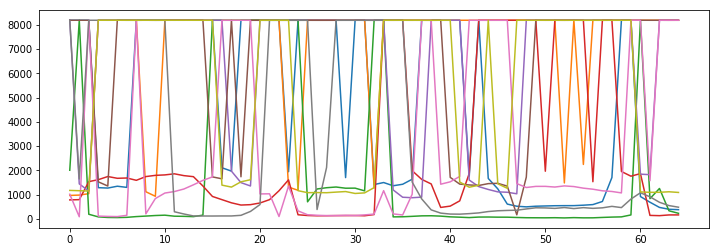

In [19]:
d = p.load(open('robot_random_joint_movements4.p', 'rb'))
lidars = np.array(list(d['lidar_data'].values))
plt.figure(figsize=(12, 4))

plt.plot(lidars)
plt.show()